## ssd---使用Ｇluon
这一章下面我们将实现.[上一章](./object-detection.md)介绍的SSD来检测野生皮卡丘。
![](../img/pikachu.png)
## 数据集
为此我们合成了一个人工数据集。我们首先使用一个开源的皮卡丘3D模型，用其生成1000张不同角度和大小的照片。然后将其随机的放在背景图片里。我们将图片打包成`rec`文件，这是一个MXNet常用的二进制数据格式。我们可以使用MXNet下的[tools/im2rec.py](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py)
来将图片打包。
###
下载数据
打包好的数据可以直接在网上下载：

In [1]:
from mxnet import gluon
import mxnet as mx
import os
import numpy as np 
ctx = mx.cpu()
root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
            'gluon/dataset/pikachu/')
data_dir = '../data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}

In [2]:
root_url

'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/'

In [2]:
print(os.path.abspath('ssd_test.ipynb')) 

/home/qy/gluon-tutorials-zh/chapter_computer-vision/ssd_test.ipynb


### 读取数据集
使用`image.ImageDetIter`来读取数据。这是针对物体检测的迭代器，(Det表示Detection)
它跟`image.ImageIter`使用很类似。主要不同是它返回的标号不是单个图片标号，而是每个图片里所有物体的标号，以及其对应的边框。

In [3]:
from mxnet import image
from mxnet import nd
data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])
def get_iterators(data_shape, batch_size):
    class_names = ['pikachu'] #类名称
    num_class = len(class_names)#类的个数
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),#3*256*256
        path_imgrec=data_dir+'train.rec',
        path_imgidx=data_dir+'train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(
    data_shape, batch_size)

/home/qy/software/anaconda3/envs/gluon/lib/python3.6/site-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


### 我们读取一个批量。
可以看到标号的形状是`batch_size x num_object_per_image x`。
这里数据里每个图片里面只有一个标号。每个标号由长为5的数组表示，第一个元素是其对用物体的标号，其中`-1`表示非法物体，仅做填充使用。后面4个元素表示边框。

In [4]:
batch = train_data.next()
print(batch)
print((batch.data[0][0:1]).shape)

/home/qy/software/anaconda3/envs/gluon/lib/python3.6/site-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]
(1, 3, 256, 256)


### 图示数据
我们画出几张图片和其对应的标号。可以看到比卡丘的角度大小位置在每张图图片都不一样。

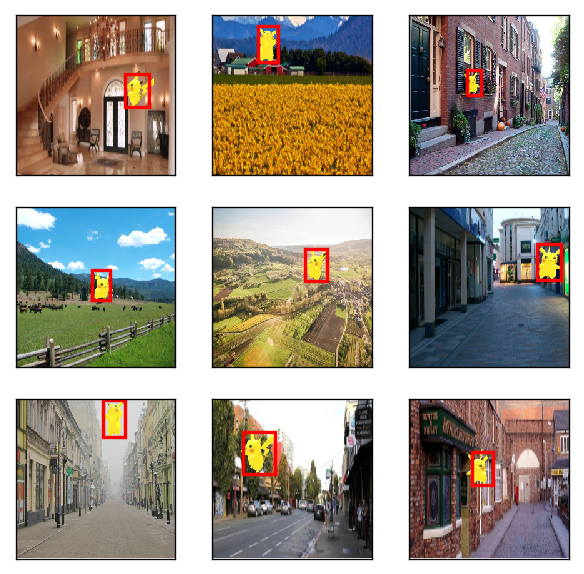

In [5]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

_, figs = plt.subplots(3, 3, figsize=(6,6))
for i in range(3):
    for j in range(3):        
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0)) + rgb_mean
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape,'red',2)
            fig.add_patch(rect)                    
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

In [6]:
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior
# shape: batch x channel x height x weight
n = 40
x = nd.random.uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5,.25,.1], ratios=[1,2,.5])

boxes = y.reshape((n, n, -1, 4))
print(boxes.shape)
# The first anchor box centered on (20, 20)
# its format is (x_min, y_min, x_max, y_max)
boxes[20, 20, 0, :]

(40, 40, 5, 4)



[0.2625 0.2625 0.7625 0.7625]
<NDArray 4 @cpu(0)>

### 预测物体类别
对每一个锚框我们需要预测它是不是包含了我们感兴趣的物体，还是只是背景。这里我们使用一个$3\times3$的卷积层来做预测，加上`pad=1`使用它的输出和输入一样。
同时输出的通道数是`num_anchors*(num_classes+1)`，每个通道对应一个锚框对某个类的置信度。假设输出是`Y`，那么对应输入中第$n$个样本的第$(i,j)$像素的置信值是在`Y[n,:,i,j]`里。具体来说，对于以`(i,j)`为中心的第`a`个锚框，
- 通道 `a*(num_class+1)` 是其只包含背景的分数
- 通道 `a*(num_class+1)+1+b` 是其包含第`b`个物体的分数

In [7]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

### 预测边界框
因为真实的边界框可以是任意形状，我们需要预测如何从一个锚框变换成真正的边界框。这个变换可以由一个长为4的向量来描述。同上一样，我们用一个有`num_anchors* 4`通道的卷积。假设输出是Y，那么对应输入中第 $n$ 个样本的第 $(i,j)$像素为中心的锚框的转换在`Y[n,:,i,j]`里。具体来说，对于第`a`个锚框，它的变换在`a*4`到`a*4+3`通道里

In [8]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

### 减半模块
我们定义一个卷积块，它将输入特征的长宽减半，以此来获取多尺度的预测。它由两个`Conv-BatchNorm-Relu`组成，我们使用填充为1的$3\times 3$卷积使得输入和输入有同样的长宽，然后再通过跨度为2的最大池化层将长宽减半。

In [9]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))#输出　num_filters　个通道数
        out.add(nn.BatchNorm(in_channels=num_filters))#归一化
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2)) 
    return out

### 合并来自不同层的预测输出
前面我们提到过SSD的一个重要性质是它会在多个层同时做预测。每个层由于长宽和锚框选择不一样，导致输出的数据形状会不一样。这里我们用物体类别预测作为样例，边框预测是类似的。
我们首先创建一个特定大小的输入，然后对它输出类别预测。然后对输入减半，再输出类别预测。
可以看到`y1`和`y2`形状不同。为了之后处理简单，我们将不同层的输入合并成一个输出。首先我们将通道移到最后的维度，然后将其展成2D数组。因为第一个维度是样本个数，所以不同输出之间是不变，我们可以将所有输出在第二个维度上拼接起来。

In [10]:
def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

### 主体网络
主体网络用来从原始像素抽取特征。通常前面介绍的用来图片分类的卷积神经网络，例如ResNet，都可以用来作为主体网络。
这里为了示范，我们简单叠加几个减半模块作为主体网络。

In [11]:
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

### 创建一个玩具SSD模型
现在我们可以创建一个玩具SSD模型了。我们称之为玩具是因为这个网络不管是层数还是锚框个数都比较小，仅仅适合之后我们之后使用的一个小数据集。但这个模型不会影响我们介绍SSD。
这个网络包含四块。主体网络，三个减半模块，以及五个物体类别和边框预测模块。其中预测分别应用在在主体网络输出，减半模块输出，和最后的全局池化层上。

In [12]:
def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))
        
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()    
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))

    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

### 计算预测

给定模型和每层预测输出使用的锚框大小和形状，我们可以定义前向函数。

In [13]:
def toy_ssd_forward(x, model, sizes, ratios, verbose=False):    
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    # feature extraction    
    x = body(x)#feature extraction完毕
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(
            x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(
            flatten_prediction(class_predictors[i](x)))
        box_preds.append(
            flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', 
                  anchors[-1].shape[1], 'anchors')
        # down sample
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max', 
                kernel=(x.shape[2], x.shape[3]))
    # concat data
    return (concat_predictions(anchors),
            concat_predictions(class_preds),
            concat_predictions(box_preds))

### 完整的模型

In [14]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales
        self.sizes = [[.2,.272], [.37,.447], [.54,.619], 
                      [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # use name_scope to guard the names
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)

    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios, 
            verbose=self.verbose)
        # it is better to have class predictions reshaped for softmax computation       
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds

## 预测

在预测阶段，我们希望能把图片里面所有感兴趣的物体找出来。

我们先定一个数据读取和预处理函数。

In [15]:
from mxnet import init
from mxnet import cpu
import os
os.makedirs('checkpoints',exist_ok=True)
filename = "checkpoints/testnet.params"
filename_2 = "checkpoints_2/ssd_net.params"
filename_3 = "checkpoints_3/ssd_net_3.params"
ctx = cpu(0)
#train_data.reshape(label_shape=(3, 5))
#train_data = test_data.sync_label_shape(train_data)
net = ToySSD(num_class)
net.load_params(filename_3, ctx=ctx)

In [16]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean
    data = data.astype('float32') - rgb_mean
    # convert to batch x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0), im

In [17]:
from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(cls_probs, box_preds, anchors,
                             force_suppress=True, clip=False)

In [18]:
path='../img/pikachu6_2.png'
path_2='../img/pikachu6.jpg'#经过旋转后的识别效果不如上图的好
path_3='../img/pikachu2.jpg'
x, im = process_image(path)
out = predict(x)
out.shape
print(out[0][0:20])


[[ 0.          0.6337336   0.09517132  0.4164515   0.25929707  0.6608266 ]
 [ 0.          0.6276029   0.40521938  0.42220128  0.6140433   0.7022898 ]
 [-1.          0.60243845  0.09184695  0.43256217  0.30487546  0.704781  ]
 [ 0.          0.598556    0.06077033  0.20080139  0.23408502  0.41945302]
 [ 0.          0.5817347   0.2931554   0.2630278   0.43930414  0.5056321 ]
 [-1.          0.53474945  0.11063086  0.4262441   0.2776322   0.6868514 ]
 [ 0.          0.5346367   0.6199095   0.22232957  0.76834416  0.50345594]
 [ 0.          0.53002626  0.7436758   0.43619734  0.9199196   0.70006055]
 [-1.          0.5282933   0.7468314   0.47016847  0.90971005  0.7037443 ]
 [-1.          0.5111046   0.6109292   0.23628788  0.778186    0.46864676]
 [ 0.          0.5040759   0.22642899  0.39759594  0.59670854  0.748411  ]
 [-1.          0.49479467  0.10122155  0.42209634  0.2542601   0.6448207 ]
 [-1.          0.49127272  0.09505249  0.41199532  0.26007748  0.6454318 ]
 [-1.          0.4898105

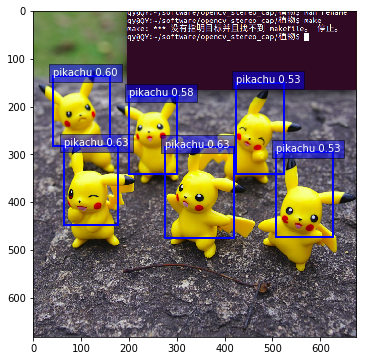

In [19]:
colors = ['blue', 'green', 'red', 'black', 'magenta']
mpl.rcParams['figure.figsize'] = (6,6)

def display(im, out, threshold=0.5):    
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]#例如０％５＝０　１％５＝１　２％５＝２
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
                        
        text = class_names[class_id]
        plt.gca().text(box[0], box[1], 
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.51)

In [1]:
from mxnet import gluon
import mxnet as mx
import os
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mxnet import image

In [2]:
from mxnet import nd

In [17]:
fname_2='./image_picha/Rectify_left_pic.png'
with open(fname_2, 'rb') as f:
        img = image.imdecode(f.read())

In [18]:
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

In [19]:
print(img.shape)

(720, 1280, 3)


In [20]:
#img =nd.transpose(img,(2,0,1))  
#print(img.shape)

In [21]:
#img_1=img.astype('float32')

In [22]:
colors = ['blue', 'green', 'red', 'black', 'magenta']

In [23]:
color=colors[0]

In [24]:
color

'blue'

In [25]:
box=np.array([468,168,793,588])

In [33]:
box

array([468, 168, 793, 588])

In [26]:
rect = box_to_rect(nd.array(box), color, 2)

In [27]:
print(rect)

Rectangle(xy=(468, 168), width=325, height=420, angle=0)


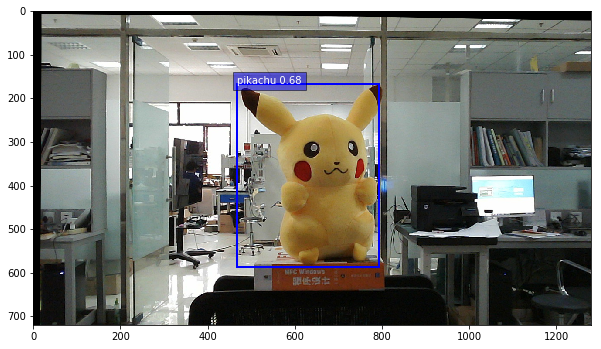

In [28]:
mpl.rcParams['figure.figsize'] = (10,10)#调节显示图片的大小
plt.imshow(img.asnumpy())#图片显示不需要转换维度
plt.gca().add_patch(rect)
text ='pikachu'
score=0.68
plt.gca().text(box[0], box[1], 
       '{:s} {:.2f}'.format(text, score),
       bbox=dict(facecolor=color, alpha=0.5),
       fontsize=10, color='white')
plt.show()

In [34]:
box_1=np.array([468,168,793,588])

In [35]:
box_txt_name='./box.txt'

In [39]:
with open(box_txt_name, 'w+') as f:
    f.write(str(box_1[0])+'\n'+str(box_1[1])+'\n'+str(box_1[2])+'\n'+str(box_1[3])
           )